# 1. Importación de los datos

In [28]:
import pandas as pd

In [29]:
# Definir los nombres de las columnas.
columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"
]

# Cargar el dataset.
df = pd.read_csv('dataset/processed.cleveland.data', names=columns, na_values='?')

# Ver las primeras filas.
print(df.head())

    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  


# 2. Preparación de datos

In [30]:
# Verificar la cantidad de valores nulos en cada columna.
print(df.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64


Eliminamos las filas con valores nulos.

In [31]:
df.dropna(inplace=True)

Vemos cuántos registros actuales tiene el dataframe.

In [32]:
print(f"Número de registros actuales: {len(df)}")

Número de registros actuales: 297


In [33]:
# Verificar los valores únicos del target.
print(df['target'].unique())

# Convertir el target a binario (1 si es mayor que 0).
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

# Verificar los cambios.
print(df['target'].value_counts())

[0 2 1 3 4]
target
0    160
1    137
Name: count, dtype: int64


Escalar las columnas numéricas. Las columnas numéricas deben estar en una escala similar para mejorar el rendimiento del modelo. (Normalizar).

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']] = scaler.fit_transform(df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']])

In [35]:
# Guardar el escalador.
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

Codificar atributos categóricos.

In [7]:
df = pd.get_dummies(df, columns=['sex', 'cp', 'thal', 'slope'])

Dividir el dataset en entrenamiento y prueba.

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((237, 21), (60, 21), (237,), (60,))

# 3. Análisis de propiedades

Calculamos las correlaciones entre atributos. Las correlaciones nos ayudan a ver qué variables están relacionadas con el target. Obtenemos una matriz de correlación:

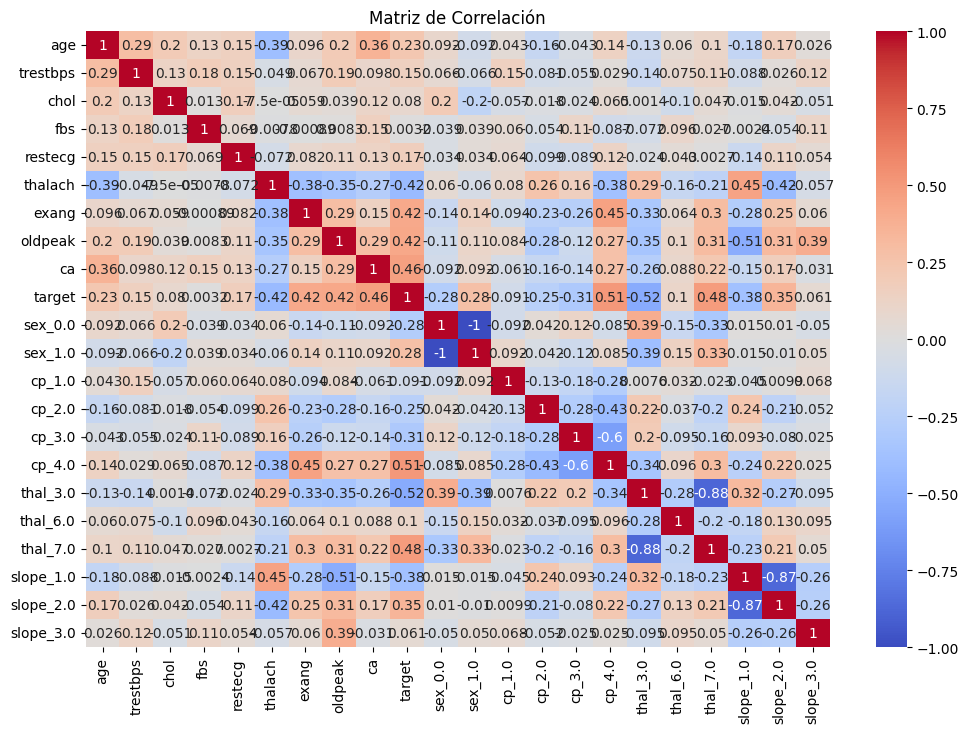

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación.
corr_matrix = df.corr()

# Visualizar la matriz de correlación.
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()

Haremos un análisis de importancia con un modelo simple. Utilizamos un modelo como el de árboles de decisión para calcular la importancia de cada atributo.

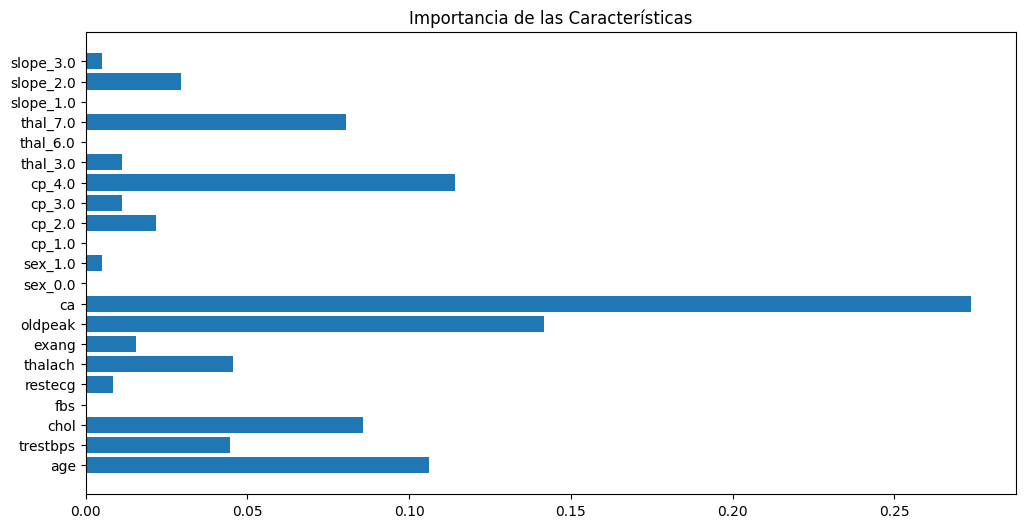

In [10]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Entrenar un modelo de árbol de decisión.
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Obtener la importancia de las características.
feature_importances = model.feature_importances_

# Crear un gráfico de barras.
features = X.columns
plt.figure(figsize=(12, 6))
plt.barh(features, feature_importances)
plt.title("Importancia de las Características")
plt.show()

# 4. Ingeniería de propiedades.

Eliminamos columnas con poca importancia.

In [11]:
df.drop(['restecg', 'fbs', 'ca'], axis=1, inplace=True)

Creamos nuevas características. Por ejemplo, combinamos trestbps y chol en un índice de riesgo cardiovascular.

In [12]:
df['risk_index'] = df['trestbps'] / df['chol']

# 5. Entrenamiento del modelo.

Realizamos el entrenamiento y la evaluación con Árbol de Decisión. Ajustamos el modelo usando GridSearchCV

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn import tree

# Definir el modelo base.
model = DecisionTreeClassifier(random_state=42)

# Definir el espacio de búsqueda de hiperparámetros.
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Configurar GridSearchCV.
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros y evaluar el modelo.
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor precisión en validación: {grid_search.best_score_:.2f}")

# Evaluar el modelo en el conjunto de prueba.
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo en el conjunto de prueba: {accuracy:.2f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1

Matriz de confusión:
[[30  6]
 [ 4 20]]
Informe de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.83      0.86        36
           1       0.77      0.83      0.80        24

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60



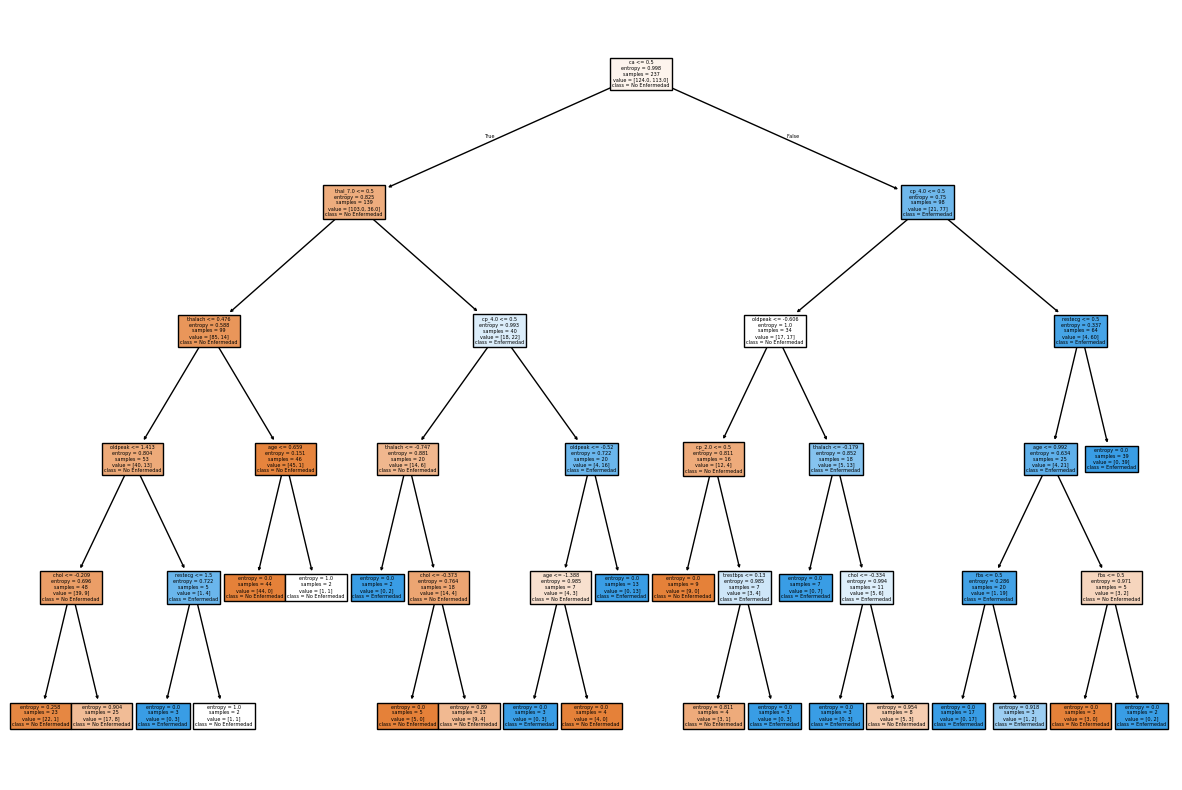

In [16]:
# Matriz de confusión.
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

# Informe de clasificación.
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))

# Visualización del Árbol de Decisión.
plt.figure(figsize=(15, 10))
tree.plot_tree(best_model, feature_names=X.columns, class_names=["No Enfermedad", "Enfermedad"], filled=True)
plt.show()

# 6. Serialización del Modelo.

Creamos un archivo llamado heart_disease_model.pkl, que contiene el modelo entrenado.

In [17]:
import joblib

# Guardar el modelo ajustado con los mejores hiperparámetros.
joblib.dump(best_model, 'heart_disease_model.pkl')
print("El modelo ha sido guardado como 'heart_disease_model.pkl'")

El modelo ha sido guardado como 'heart_disease_model.pkl'


In [18]:
# Cargar el modelo guardado.
loaded_model = joblib.load('heart_disease_model.pkl')

# Hacer una predicción de prueba.
sample_data = X_test.iloc[0:1]  # Usar la primera fila del conjunto de prueba.
prediction = loaded_model.predict(sample_data)
print(f"Predicción: {prediction[0]}")

Predicción: 0


Con este código repetimos a través de X_test y realizamos predicciones para cada fila hasta encontrar una que prediga 1.

In [24]:
# Hacer una predicción de prueba.
sample_data = None
prediction = None

# Iterar sobre el conjunto de prueba hasta encontrar una predicción de 1.
for index in range(len(X_test)):
    sample_data = X_test.iloc[[index]]  # Seleccionar una fila del conjunto de prueba.
    prediction = loaded_model.predict(sample_data)
    if prediction[0] == 1:
        break  # Salir del bucle si la predicción es 1.

# Imprimir la predicción y los datos correspondientes.
print(f"Datos de prueba: {sample_data.to_dict(orient='records')[0]}")
print(f"Predicción: {prediction[0]}")

Datos de prueba: {'age': -0.2813759515173772, 'trestbps': -1.1105700562245104, 'chol': -0.33423575689921425, 'fbs': 0.0, 'restecg': 0.0, 'thalach': 0.4541202235687229, 'exang': 0.0, 'oldpeak': -0.9067116273231403, 'ca': 1.0, 'sex_0.0': False, 'sex_1.0': True, 'cp_1.0': False, 'cp_2.0': False, 'cp_3.0': False, 'cp_4.0': True, 'thal_3.0': True, 'thal_6.0': False, 'thal_7.0': False, 'slope_1.0': True, 'slope_2.0': False, 'slope_3.0': False}
Predicción: 1


Con este código repetimos a través de X_test y realizamos predicciones para cada fila hasta encontrar una que prediga 0.

In [25]:
# Hacer una predicción de prueba.
sample_data = None
prediction = None

# Iterar sobre el conjunto de prueba hasta encontrar una predicción de 0.
for index in range(len(X_test)):
    sample_data = X_test.iloc[[index]]  # Seleccionar una fila del conjunto de prueba.
    prediction = loaded_model.predict(sample_data)
    if prediction[0] == 0:
        break  # Salir del bucle si la predicción es 0.

# Imprimir la predicción y los datos correspondientes.
print(f"Datos de prueba: {sample_data.to_dict(orient='records')[0]}")
print(f"Predicción: {prediction[0]}")

Datos de prueba: {'age': -1.0561846974837705, 'trestbps': -1.1105700562245104, 'chol': -1.6827242851225133, 'fbs': 0.0, 'restecg': 0.0, 'thalach': -0.5064565134976521, 'exang': 0.0, 'oldpeak': -0.9067116273231403, 'ca': 0.0, 'sex_0.0': True, 'sex_1.0': False, 'cp_1.0': False, 'cp_2.0': True, 'cp_3.0': False, 'cp_4.0': False, 'thal_3.0': True, 'thal_6.0': False, 'thal_7.0': False, 'slope_1.0': False, 'slope_2.0': True, 'slope_3.0': False}
Predicción: 0


# 7. Pruebas.

Creamos un archivo llamado app.py en el proyecto, y escribimos el código necesario para construir la API.

## Código para encontrar registros donde target = 1.

In [20]:
# Filtrar ejemplos donde target = 1
examples_with_disease = df[df['target'] == 1]

# Mostrar algunas filas
print(examples_with_disease.head(10))

         age  trestbps      chol   thalach  exang   oldpeak  target  sex_0.0  \
1   1.378929  1.596266  0.744555 -1.816334    1.0  0.381773       1    False   
2   1.378929 -0.659431 -0.353500 -0.899420    1.0  1.326662       1    False   
6   0.825494  0.468418  0.397801  0.454120    0.0  2.185652       1     True   
8   0.936181 -0.095506  0.128103 -0.113493    0.0  0.295874       1    False   
9  -0.170689  0.468418 -0.854367  0.235807    1.0  1.756157       1    False   
12  0.161372 -0.095506  0.166631 -0.331806    1.0 -0.391318       1    False   
16 -0.724124 -1.223355 -0.353500  0.803421    0.0 -0.047722       1    False   
22  0.382746 -0.659431  0.706027  0.454120    0.0  0.639470       1    False   
23  0.382746  0.017278 -0.449820  1.021734    0.0  1.842056       1    False   
24  0.604120 -0.095506 -0.796575 -0.768432    1.0  1.154864       1    False   

    sex_1.0  cp_1.0  cp_2.0  cp_3.0  cp_4.0  thal_3.0  thal_6.0  thal_7.0  \
1      True   False   False   False    Tru

In [21]:
print(examples_with_disease.describe())

              age    trestbps        chol     thalach       exang     oldpeak  \
count  137.000000  137.000000  137.000000  137.000000  137.000000  137.000000   
mean     0.245397    0.165875    0.086763   -0.458013    0.540146    0.458267   
std      0.874390    1.065632    0.957040    0.991607    0.500215    1.120987   
min     -2.163054   -1.787279   -2.241384   -3.431849    0.000000   -0.906712   
25%     -0.170689   -0.659431   -0.565405   -1.074070    0.000000   -0.391318   
50%      0.382746   -0.095506    0.108839   -0.331806    1.000000    0.295874   
75%      0.825494    0.750380    0.706027    0.323132    1.000000    1.240763   
max      2.485798    3.851964    3.114042    1.982310    1.000000    4.419026   

       target  risk_index  
count   137.0  137.000000  
mean      1.0   -0.502946  
std       0.0   12.554915  
min       1.0  -97.724261  
25%       1.0   -0.928116  
50%       1.0    0.008490  
75%       1.0    1.261253  
max       1.0   75.065086  


### Ejemplo en formato JSON para Postman con target=1:
{
  "age": -0.2813759515173772,
  "trestbps": -1.1105700562245104,
  "chol": -0.33423575689921425,
  "fbs": 0.0,
  "restecg": 0.0,
  "thalach": 0.4541202235687229,
  "exang": 0.0,
  "oldpeak": -0.9067116273231403,
  "ca": 1.0,
  "sex_0.0": false,
  "sex_1.0": true,
  "cp_1.0": false,
  "cp_2.0": false,
  "cp_3.0": false,
  "cp_4.0": true,
  "thal_3.0": true,
  "thal_6.0": false,
  "thal_7.0": false,
  "slope_1.0": true,
  "slope_2.0": false,
  "slope_3.0": false
}

### Ejemplo en formato JSON para Postman con target=0:

{
  "age": -1.0561846974837705,
  "trestbps": -1.1105700562245104,
  "chol": -1.6827242851225133,
  "fbs": 0.0,
  "restecg": 0.0,
  "thalach": -0.5064565134976521,
  "exang": 0.0,
  "oldpeak": -0.9067116273231403,
  "ca": 0.0,
  "sex_0.0": true,
  "sex_1.0": false,
  "cp_1.0": false,
  "cp_2.0": true,
  "cp_3.0": false,
  "cp_4.0": false,
  "thal_3.0": true,
  "thal_6.0": false,
  "thal_7.0": false,
  "slope_1.0": false,
  "slope_2.0": true,
  "slope_3.0": false
}